## Introduction

SOTA 성능을 내는 많은 detector에서 anchor를 활용해서 BBox coordination을 학습합니다. <br>
이번 글에서는 anchor가 무엇인지, 어떻게 one-stage, two-stage detector에서 사용되는지에 관해 살펴보겠습니다.

이 글에 사용된 script 및 jupyter notebook은 [medipixel repository](https://github.com/medipixel/Object-Detection-Tutorial/tree/master/src/anchor)에 업로드 되어 있으니 참고하시기 바랍니다.

코드 위주로 소개하기 때문에 object detection, anchor가 익숙하지 않으신 분께서는 Andrew Ng 교수님이 소개하시는 [영상](https://www.youtube.com/watch?v=SXmsPXsYkTw)과 Jonathan Hui의 object detection [소개 자료](https://medium.com/@jonathan_hui/what-do-we-learn-from-region-based-object-detectors-faster-r-cnn-r-fcn-fpn-7e354377a7c9)를 보시면 이해에 도움이 되실겁니다.

## Import Libraries

코드는 [mmdet.v0.6rc0](https://github.com/open-mmlab/mmdetection/tree/v0.6rc0)을 기준으로 참고하여 제작하였습니다. 

In [1]:
%load_ext autoreload

%autoreload 2

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import torch
import torch.nn.functional as F

from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [2]:
from anchor_generator import (gen_base_anchors, get_anchors, 
                              grid_anchors, meshgrid)
from assigner import assign_wrt_overlaps, bbox_overlaps
from loss import binary_cross_entropy, smooth_l1_loss
from prediction import predict_anchors
from transforms import bbox2delta, delta2bbox
from visualize import (draw_anchor_gt_overlaps, draw_anchor_samples_on_image, 
                       draw_base_anchor_on_grid, draw_pos_assigned_bboxes)

---
## What is Anchor?

- 첫 등장: anchor라는 개념은 [Faster R-CNN](https://arxiv.org/abs/1506.01497.pdf)에서 처음으로 제안되었습니다.
- 주요 사용처: anchor는 대부분의 one-stage, two-stage detector에서 사용하며 대표적으로는 [RetinaNet](https://arxiv.org/abs/1708.02002.pdf)(one-stage)와 Faster R-CNN(two-stage)가 존재합니다. [[1]](#ref_1)
- anchor를 사용하는 목적
    - object detection 문제에서 우리는 이미지 상에 물체 (object)가 있는 영역을 예측하여 Bounding Box(BBox)를 그려야 합니다. <br>
	이 때에, 이미지 전체를 한꺼번에 보고 특정 위치를 예측하는 것보다 특정 영역 BBox만을 보고 이 안에 물체가 있는지를 예측하는 편이 더 쉽습니다. <br>
	따라서 이미지 상에 균일하게 많은 BBox(즉, anchor)를 그린 뒤에 이 anchor들 중 gt와 서로 겹치는 영역의 넓이를 기준으로 선별된 Anchor를 학습에 활용하게 됩니다.
    - 각 object detector 모델은 위 과정을 통해 선별된 anchor를 이용하여 **anchor와 정답(ground-truth)과의 차이**에 대해서 예측하도록 학습하게 됩니다. (BBox regression) <br>
	(이 때, anchor의 크기가 적절하지 못한 경우에는 차이의 편차가 커지게 될 것이므로 학습이 어려워질 수 있어서 적절한 크기를 선정하는게 중요합니다.)
    - anchor는 균일한 간격, 일정한 규칙으로 생성 하여, 물체가 특정 위치에 존재할 때만 탐지가 잘 되거나, 혹은 특정 위치에서는 탐지가 잘 되지 않는 현상을 줄입니다. 이러한 특성을 translation-Invariance라고 하며, 대부분의 object detector 모델이 개선하려고 노력하는 특징입니다. [[2]](#ref_2)
- Parameters 설명
    - scale: feature map에서의 anchor 크기(scale)입니다.
    - ratio: feature map에서의 anchor 비율(ratio)입니다.
    - stride: 이미지를 기준으로 어느 정도 간격으로 anchor를 생성할 것인지 나타내는 값입니다.(주로 이미지와 feature map 크기의 비율 값을 사용합니다.)
        - scale과 ratio가 feature map 내에서의 `anchor_base_size`를 만들게 됩니다.
        - feature map의 크기는 이미지의 너비, 높이를 `stride`로 나눈 값이기 때문에 이게 반영된 이미지에서의 anchor 크기는 `anchor_base_size * stride` 입니다.

---

## How to draw grid anchors
이제부터 anchor를 이미지 상에 그리기 위하여 `base_anchor`와 `stride`에 대하여 알아보겠습니다.

1. `base_anchor`
	- 하나의 anchor bbox는 left top, right bottom의 x, y 좌표를 각각 따서 `[x1, y1, x2, y2]`로 표현할 수 있습니다.
	- 한 이미지 위에 그려진 anchor의 집합을 뜻하는 `grid_anchor`는 feature map의 예측 값에 매칭되어야 하기 때문에 feature map과 동일한 width, height를 가지며 channel은 4로 갖습니다.
	- `base_anchor`는 scale, ratio 2개 parameter로 결정되는 anchor의 작은 집합이며 모든 bbox가 같은 중심을 갖습니다. 크기 단위는 **1 `anchor_base_size`** 입니다. [[3]](#ref_3)
		- RetinaNet의 경우 Octave scale을 사용하였습니다. Faster R-CNN에서 사용한, $2,4,6$ 등 $n$배로 올라가는 scale 간격 대신 $2^0, 2^{\frac 1 3}, 2^{\frac 2 3}$과 같이 (base scale)^(octave scale)을 사용하였습니다. [[4]](#ref_4)
		- `anchor_base_size`는 주로 feature map의 이미지 대비 stride 값으로 많이 사용하며 이런 경우, feature map이 작은 경우 stride가 커지고 anchor bbox도 커져서 큰 물체를 검출하기에 적합해집니다. 반대의 경우엔 작은 물체를 검출하기에 적합합니다.
			- 통상적으로 CNN이 작은 feature map이 high-level 정보를 잘 나타내어 큰 물체 정보를 잘 다루기 때문에 `anchor_base_size`를 stride로 사용하는 것이 합리적입니다. 반대의 경우엔 작은 물체 정보를 잘 다루기 때문에 마찬가지로 `anchor_base_size`를 stride로 다루는 것이 합리적입니다.

2. `stride`
	- feature map 상에서 grid cell의 간격은 실제 이미지 상에서 1 stride (`image_width(height) // feature_map_width(height)`) 입니다.
	- 즉, 이미지 상에서 생각하면 anchor의 중심 좌표가 stride 만큼 떨어져서 존재하고 그 위에 `base_anchor`가 그려진다고 볼 수 있습니다.
		- 이렇게 이미지 상에 그려진 것을 가정한 `anchors`는 각 bbox 들에 존재하는(혹은 존재하지 않는) 물체를 예측하도록 학습할 때 사용됩니다.


---

### Settings
anchor를 그리기 위한 hyperparameter들을 설정하겠습니다.

- `gt_bboxes_list`: 예측하고자 하는 정답인 gt의 bbox 목록입니다.
	- gt bbox 크기를 크게 잡으면 다양한 positive anchor 후보들이 생기는 것을 확인할 수 있습니다.
- `scales`, `ratios`: `base_anchor`의 크기를 조정해주는 값입니다. 이 값들을 조정하면 anchor bbox의 형태를 편향되게 만들 수 있습니다.
- `anchor_base_size`: feature map 상에 존재하는 anchor가 이미지 상에서 존재할 때의 크기를 결정해주는 비율 값입니다. 
	- `anchor_stride`(`image_size` // `featmap_size`)의 값을 주로 갖습니다.
	- 이 자료에서는 `anchor_base_size == anchor_stride == image_size // featmap_size`를 가정하겠습니다.

이번 자료에서는 1개 feature map에 대해서만 anchor 분석을 진행하겠습니다. multi-level feature map([FPN](https://arxiv.org/abs/1612.03144.pdf) 등)이 사용되는 경우는 후속 자료에서 살펴보도록 하겠습니다.

In [3]:
base_size = anchor_stride = 32
scales = torch.Tensor([2, 4, 8])
ratios = torch.Tensor([0.5, 1.0, 2.0])
featmap_size = [16, 16]
device = 'cpu'
image_shape = [256, 256, 3]
anchors_per_grid = len(scales) * len(ratios)

# x1y1x2y2
gt_bboxes_list = torch.FloatTensor([[32, 32, 32*3, 32*3]]).to(device)

---
### Base Anchor
간단한 `base_anchor`를 생성하여 feature map의 첫 번째 grid cell 위치에 해당하는 이미지 상의 좌표에 그려보겠습니다.
이 `base_anchor`가 실제 실행시에는 `scales` \* `ratios`의 개수만큼 생성되며 feature map 의 각 grid cell의 위치에 존재하게 됩니다.

- 각 feature map의 grid cell은 원래의 이미지를 기준으로 하는 좌표를 가지고 있습니다. 이 좌표들마다 `base_anchor`를 위치시키면 (feature map 기준 각 grid cell에 `base_anchor`가 존재하게 되면) 이미지 기준으로 stride 만큼 띄엄띄엄 `base_anchor`가 존재하는 모습을 볼 수 있습니다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


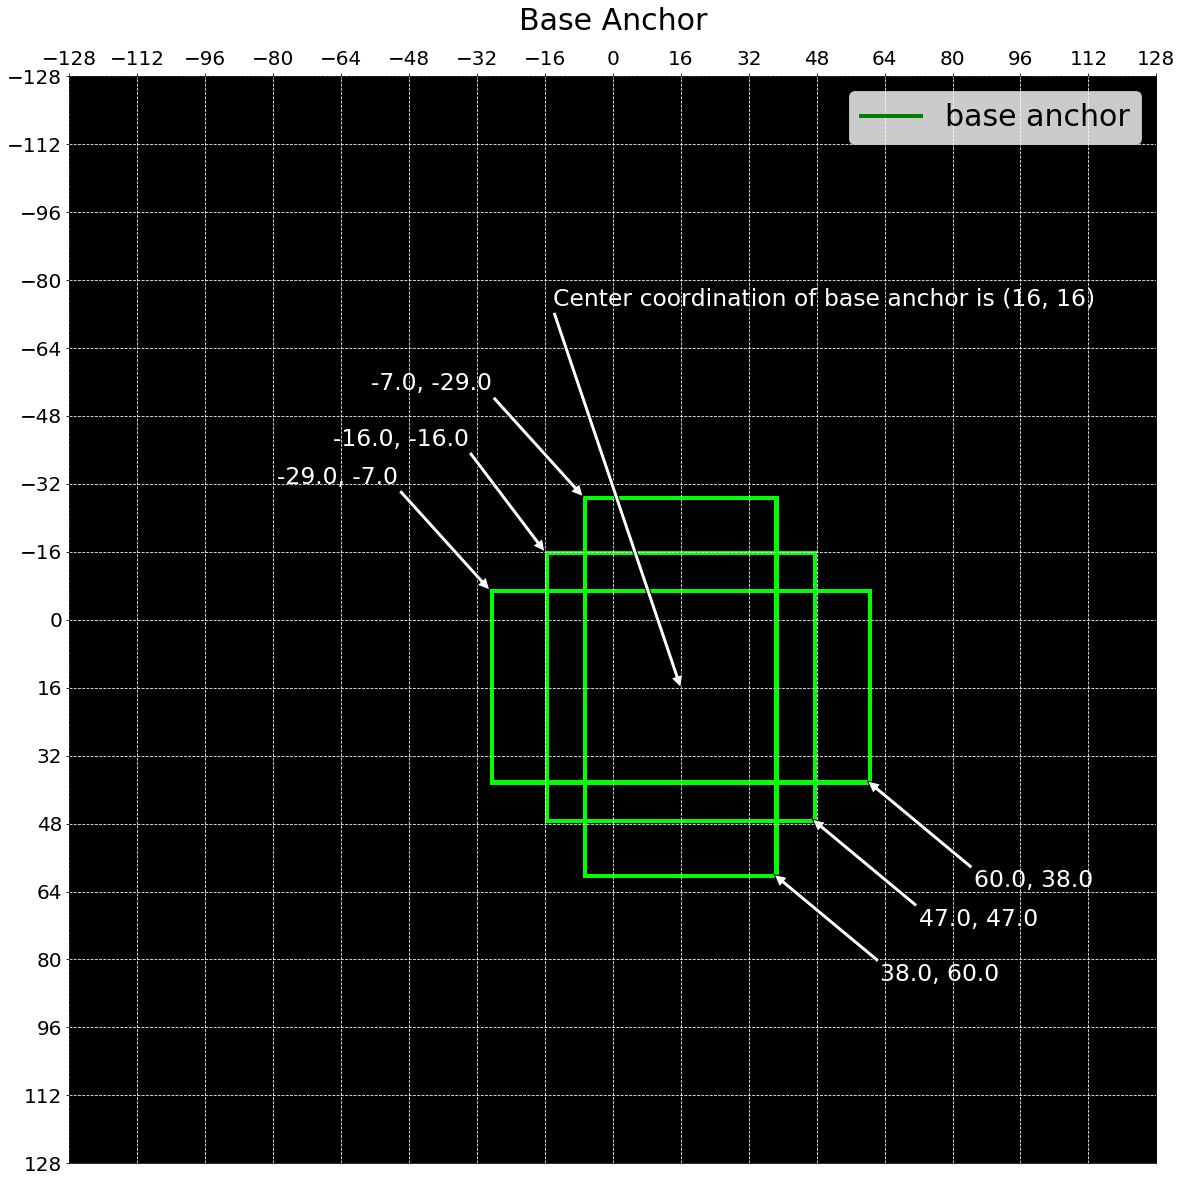

In [4]:
base_anchor = gen_base_anchors(base_size, ratios, scales[:1])
draw_base_anchor_on_grid(base_anchor, base_size)

각 좌표에 위치한 `base_anchor`를 한 번에 그리면 도저히 알아볼 수 없을 정도로 빽빽한 사각형들이 만들어지기 때문에 몇 개의 샘플만을 시각화하고 실제 이미지 상에서 어떤 규칙으로 anchor를 그려내는지 확인해보겠습니다.<br>
아래 그림에서 각각의 anchor들이 일정한 거리(`shifts`)를 간격으로 하여 만들어지는 것을 볼 수 있습니다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


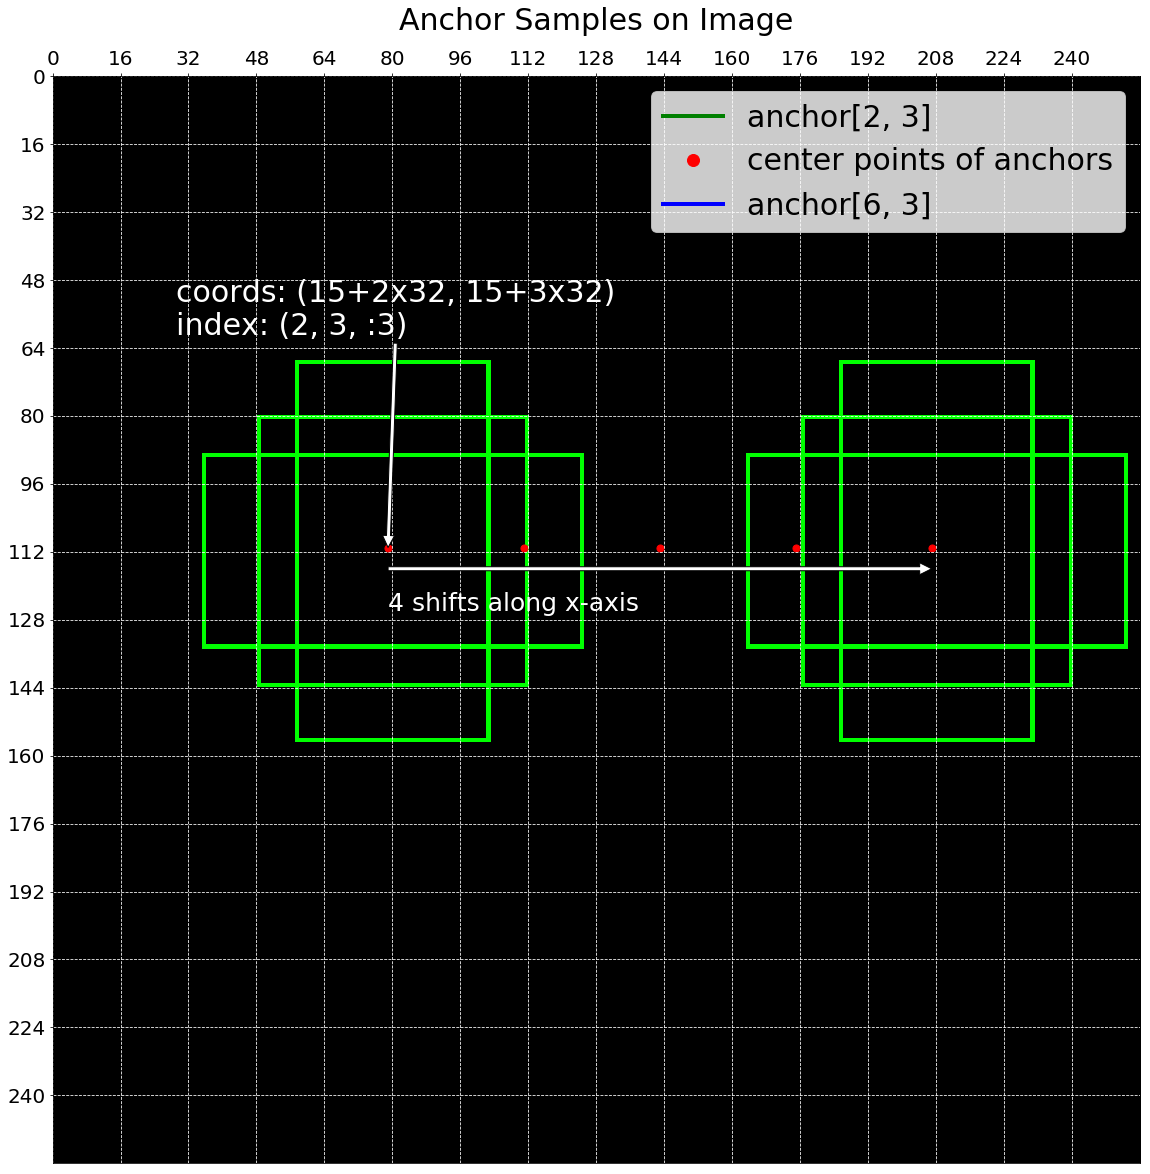

In [5]:
draw_anchor_samples_on_image(image_shape, base_size, featmap_size, scales, ratios)

`get_anchors`는 `gen_base_anchor`로 `base_anchor`를 만들고, feature map의 위치를 나타내는 grid에 `base_anchor`를 더하고 각 anchor의 valid 여부를 계산해서 `anchors, flags`를 반환하는 함수입니다. <br>
각 step 별 상세한 내용은 [코드](https://github.com/medipixel/Object-Detection-Tutorial/blob/master/src/anchor/anchor_generator.py)를 참고해주시기 바랍니다.

In [6]:
anchors, flags = get_anchors(image_shape, featmap_size, base_size, anchor_stride, scales, ratios, device)

In [5]:
# feature map 32x32 각 pixel에 9개의 anchors
assert anchors.shape[0] == featmap_size[0] * featmap_size[1] * 9
# anchor를 사용할 지 말지 결정하는 flags와 anchors의 개수는 같아야 합니다.
assert len(flags) == len(anchors)

NameError: name 'anchors' is not defined

---
## Anchor Selection
각 anchor들은 gt와의 overlap 정도에 따라 positive, negative로 나뉘고 각각을 샘플링해서 학습에 활용합니다.

- one-stage에서는 positive anchor에 1, negative anchor에 0을  배정해서 [`RPNHead`](https://github.com/open-mmlab/mmdetection/blob/v0.6rc0/mmdet/models/anchor_heads/rpn_head.py)를 학습합니다.
- two-stage에서는 positive anchor에 가장 overlap이 큰 gt의 class를 배정하고 negative anchor에 0을 배정해서 [`BBoxHead`](https://github.com/open-mmlab/mmdetection/blob/v0.6rc0/mmdet/models/anchor_heads/retina_head.py)를 학습합니다.
- positive anchor는 classification, regression 학습 모두에 활용됩니다. 그래야 특정 BBox에 대해서 object의 class와 BBox 좌표을 예측할 수 있게 됩니다.
- negative anchor는 classification에만 활용됩니다. 그 이유는 negative의 경우 background라는 정보는 가지고 있지만, 어느 위치에 물체가 있다는 정보는 가지고 있지 않기 때문입니다. [[5]](#ref_5)
- overlap은 [IoU(Intersection over Union)](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/)를 통해 계산합니다.



In [8]:
overlaps = bbox_overlaps(gt_bboxes_list, anchors)
assert overlaps.shape == (len(gt_bboxes_list), anchors.shape[0])

anchor와 gt의 bbox `overlaps`인 IoU 값을 feature map에 나타내보겠습니다. 파란색 box는 gt의 위치를 나타내며 gt와 가까울 수록 IoU 값이 커지는 것을 볼 수 있습니다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


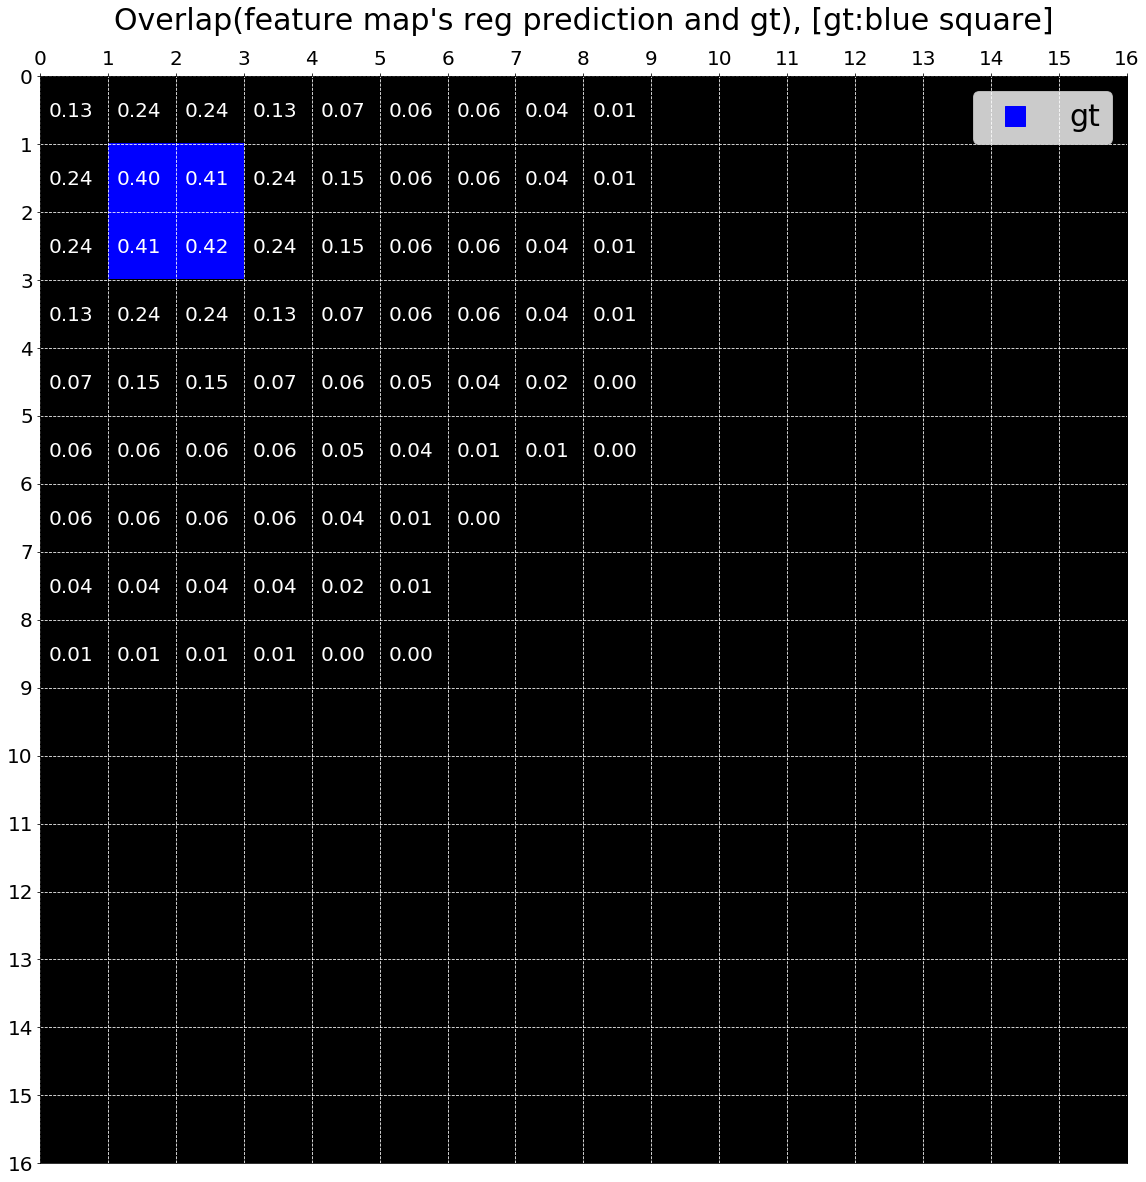

In [10]:
draw_anchor_gt_overlaps(overlaps, gt_bboxes_list, featmap_size, 
                        anchors_per_grid, anchor_stride=anchor_stride, draw_gt=True)

위 그림에서 gt를 제거하고 `overlaps`인 IoU 값을 위치 별로 heatmap으로 나타내었습니다. 역시나, gt에 가까워질 수록 IoU 값이 커지는 것을 알 수 있습니다.

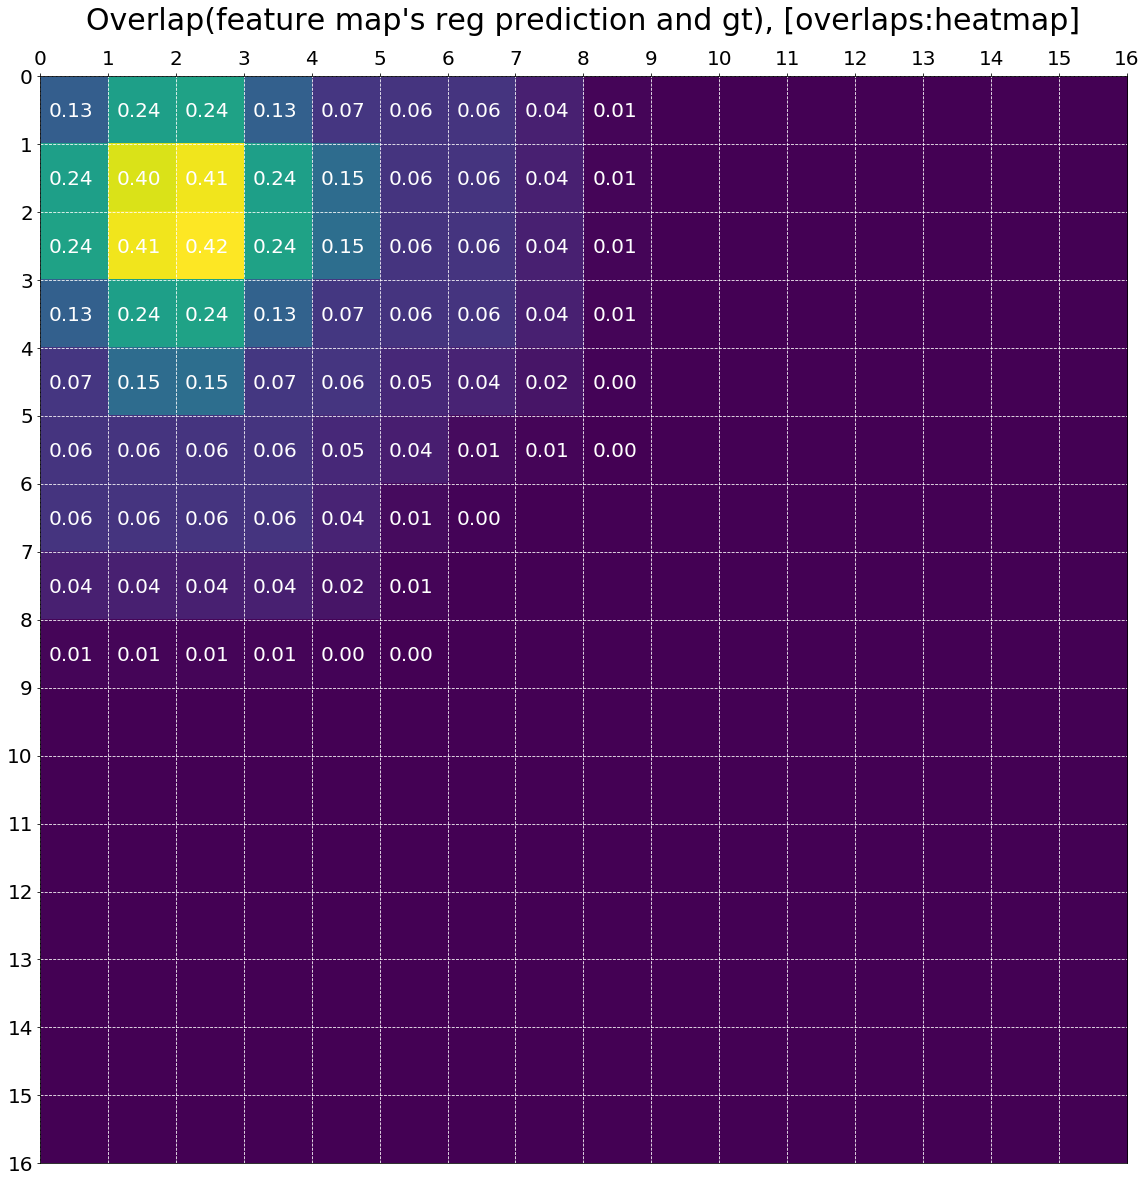

In [11]:
draw_anchor_gt_overlaps(overlaps, gt_bboxes_list, featmap_size, anchors_per_grid, anchor_stride)

In [ ]:
아래 코드에서는 `overlaps`를 이용하여 각 anchor를 postive sample 또는 negative sample로 할당합니다. <br>
gt와의 IoU가 높은 anchor를 positive sample로 삼고, IoU가 낮은 anchor를 무작위로 positive sample 개수만큼 뽑아 negative sample로 사용합니다. <br>
그리고 학습을 하기 위해서 classification, regression의 label을 구성합니다.(`pos_neg_cls_label`, `pos_gt_bboxes`)

In [12]:
# gt와의 overlap에 따라 pos, negative를 배정합니다.
num_gts, assigned_gt_inds, max_overlaps = assign_wrt_overlaps(overlaps)

In [13]:
# positive indices
pos_inds = torch.nonzero(assigned_gt_inds > 0).squeeze(-1).unique()
# negative indices
neg_inds = torch.nonzero(assigned_gt_inds == 0).squeeze(-1).unique()

In [14]:
# positive와 1:1 비율로 학습에 사용할 negative sample을 얻습니다.
sampled_neg_inds = neg_inds[torch.randint(0, len(neg_inds), size=(len(pos_inds),))]
# positive, negative의 label을 0, 1로 구성합니다.
pos_neg_cls_label = torch.cat([torch.ones(len(pos_inds)),
                               torch.zeros(len(sampled_neg_inds))])

In [16]:
bboxes = anchors  # bboxes
pos_bboxes = bboxes[pos_inds]  # positive boxes
pos_assigned_gt_inds = assigned_gt_inds[pos_inds] - 1
pos_gt_bboxes = gt_bboxes_list[pos_assigned_gt_inds, :]

---
## Anchor as a Target
앞서 언급한 것 처럼 anchor를 학습에 사용하기 위하여 **gt-anchor 차이**를 계산합니다. <br>
이 과정은 [[6]](#ref_6) anchor bbox를 coordination(`[x1, y1, x2, y2]`) 형태에서 target(`target_delta`)으로 변환해주는 과정을 의미합니다.(`bbox2delta`) 

In [17]:
# target_deltas는 특정 pos_inds에 대한 것이며 이 inds에 할당된 anchor를 기준으로만 loss가 계산이 되도록 해야 합니다.
target_deltas = bbox2delta(pos_bboxes, pos_gt_bboxes)

In [18]:
# 변환이 제대로 되었는지 확인합니다. 
bboxes_reversed = delta2bbox(pos_bboxes, target_deltas)
assert torch.equal(bboxes_reversed[0], gt_bboxes_list[0])

---
## Train anchor
anchor target을 만들었다면 앞에서 나온 feature를 network(`anchor_head`)를 통과시켜 <br> &ensp; &ensp; 1) regression 예측 값(`reg_pred`)으로 delta를 예측 <br> &ensp; &ensp; 2) class 예측 값(`cls_pred`)으로 실제 class를 예측 <br>
&ensp; &ensp; 하도록 학습시키면 모델이 anchor를 기반으로 object의 class와 위치 정보를 예측할 수 있게 됩니다.

- loss는 one/two-stage network 마다 다르게 적용되나 공통적으로 regression은 [smooth-l1](https://github.com/rbgirshick/py-faster-rcnn/files/764206/SmoothL1Loss.1.pdf)를, classification은 [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy)를 가장 많이 사용합니다.
- loss 계산에는 positive, negative sample을 모두 다 사용할 수는 있지만, positive sample에 비해 negative sample의 개수가 압도적으로 많으므로, 일부 정해진 숫자 만큼만의 sample을 선정하여 학습에 사용합니다. <br> (e.g. positive:negative=1:1.) [[7]](#ref_7)
- 이렇게 anchor prediction을 구하고 그 중에 `neg_inds`, `pos_inds`에 해당하는 결과만 가져오는 과정을 거쳐 최종 예측결과인 `pos_neg_cls_pred`, `pos_delta_pred`를 구합니다.
- loss를 구한 뒤에 gradient descent 하는 과정은 생략하겠습니다.

In [19]:
pos_neg_cls_pred, pos_delta_pred = predict_anchors(anchors.shape, target_deltas, sampled_neg_inds)

In [20]:
# regression, class loss를 각각 계산합니다.
reg_loss = smooth_l1_loss(pos_delta_pred, target_deltas, beta=1.0)
print("reg_loss:", reg_loss)
cls_loss = binary_cross_entropy(pos_neg_cls_pred, pos_neg_cls_label)
print("cls_loss:", cls_loss)

reg_loss: tensor(0.0795)
cls_loss: tensor(2.7997)



---
## Test
- feature map을 받아 bbox의 `cls_pred`, `delta_pred`를 예측할 때 **delta를 예측하기 때문에**, delta를 bbox로 변환해주는 과정이 필요합니다.(`delta2bbox`)
	- **delta는 gt-anchor의 차이**라는 점을 참고하시면 anchor bbox의 coordination 정보를 바탕으로 재변환을 수식적으로 풀어가는 과정을 어렵지 않게 이해하실 수 있습니다.
- 최종적으로 object 예측 결과는 `cls_pred`가 특정 threshold 이상인 값들에 대해서 [Non-maximum suppresion(NMS)](https://en.wikipedia.org/wiki/Canny_edge_detector#Non-maximum_suppression)를 통과시킨 결과입니다.
- `cls_pred` threshold, nms가 모두 고려되었다고 가정하고 위에서 얻은 `pos_delta_pred`를 test 결과로 얻었다고 가정하겠습니다.


- `cls_pred` threshold, nms가 모두 고려되었다고 가정하고 위에서 얻은 `pos_delta_pred`를 test 결과로 얻었다고 가정하겠습니다.

In [21]:
pos_bboxes_pred = delta2bbox(pos_bboxes, pos_delta_pred)

아래 그림에서는 positve prediction들에 대해서 예측한 값을 순서대로 나타내었습니다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


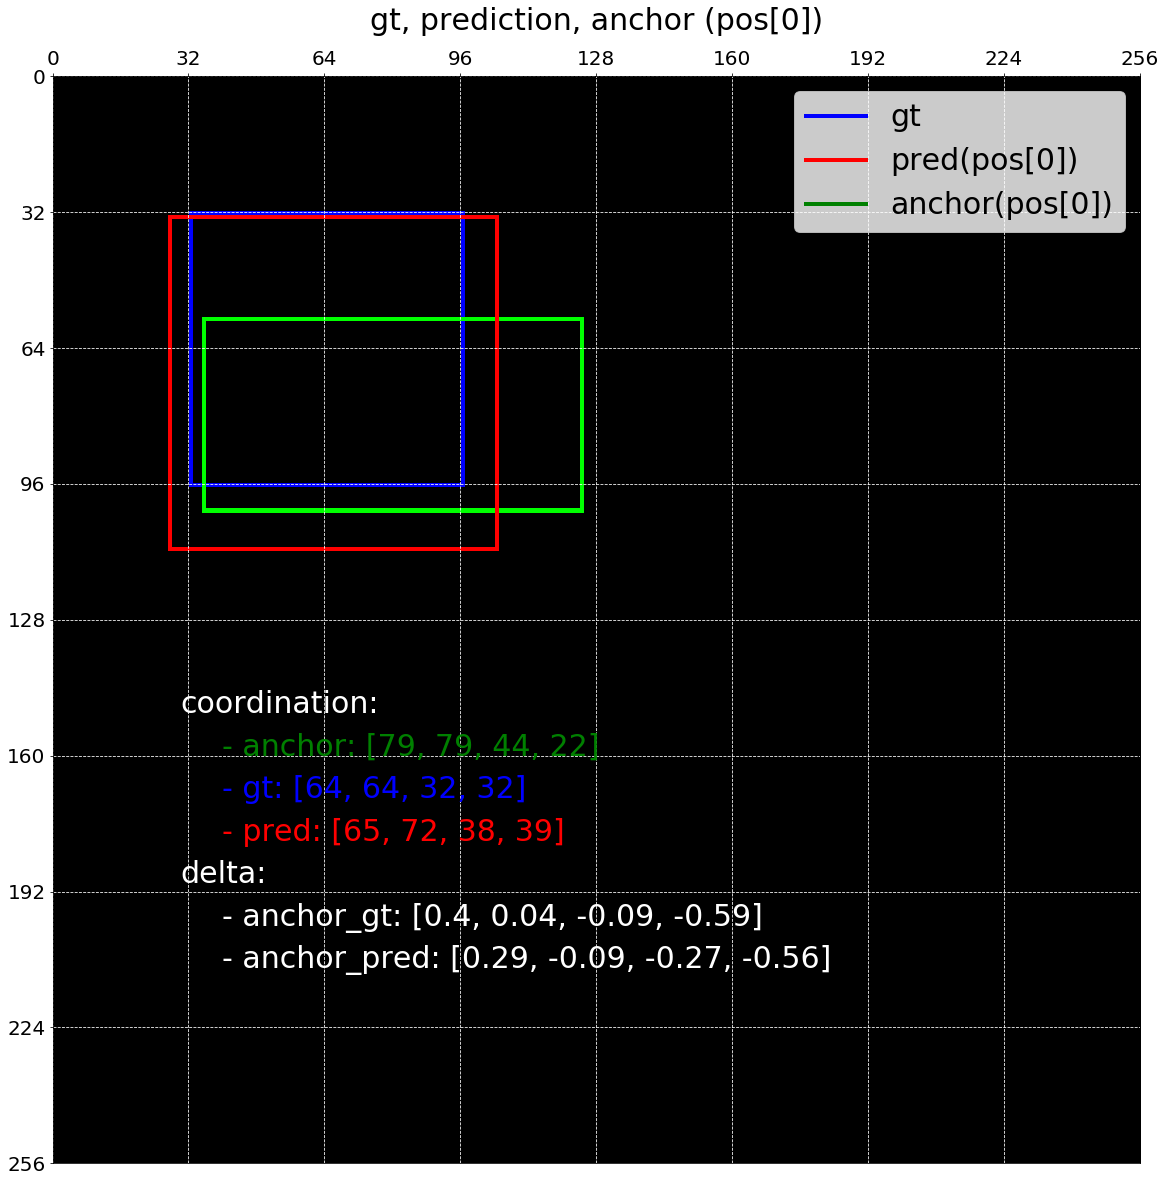

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


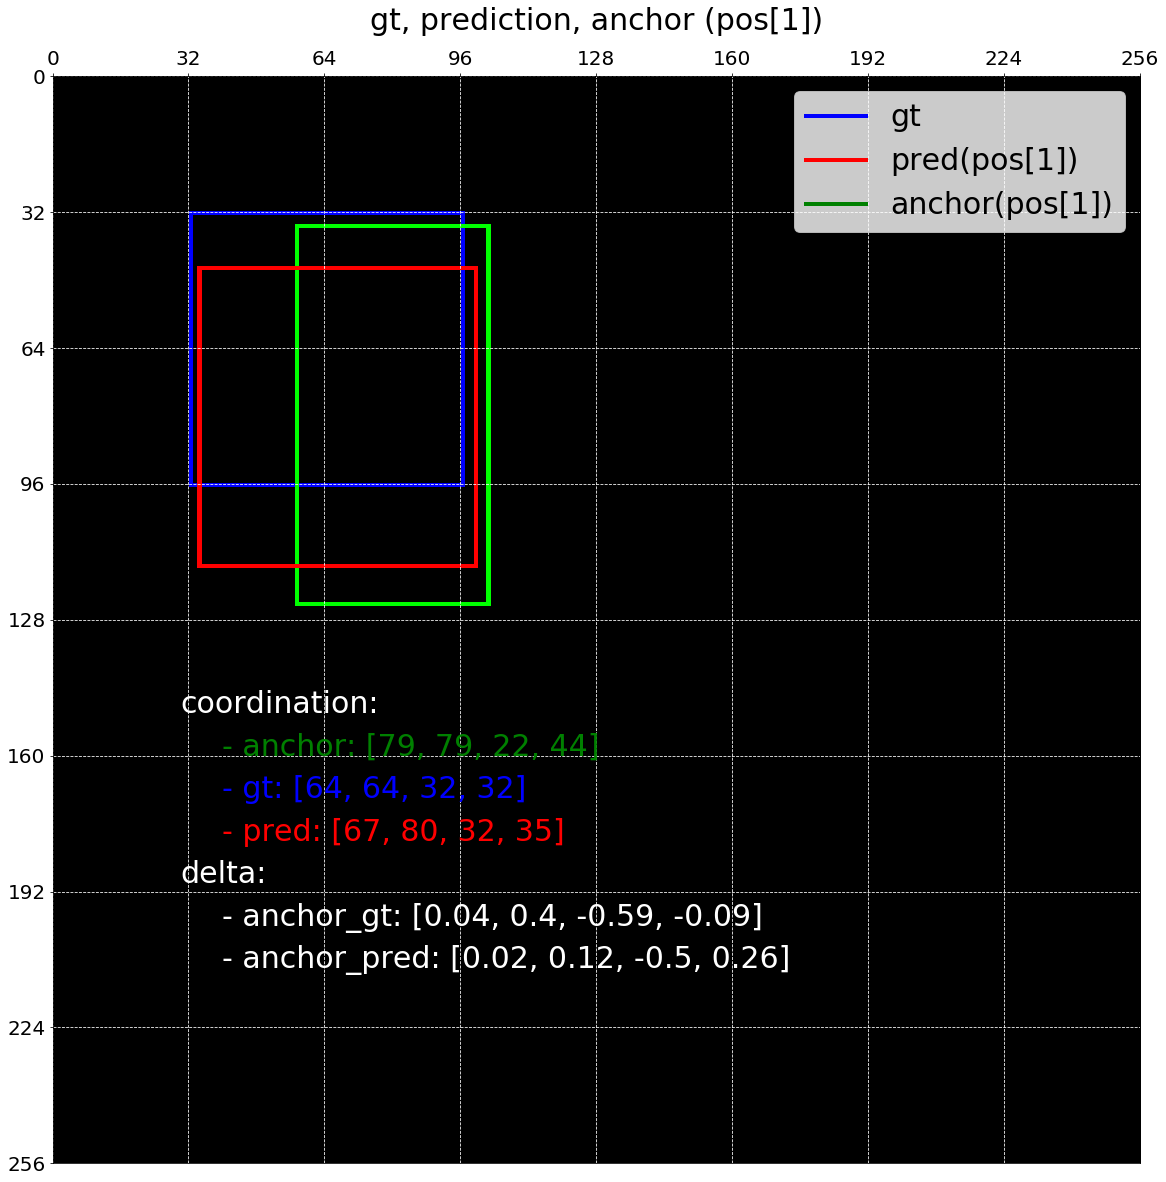

In [22]:
# blue: gt, green: anchor, red: prediction32, 32, 9
draw_pos_assigned_bboxes(image_shape, base_size, gt_bboxes_list, pos_bboxes, pos_bboxes_pred)

## Reference

---
### Faster R-CNN
**[1]** Translation-Invariant Anchors
     An important property of our approach is that it is translation invariant, both in terms of the anchors and the functions that compute proposals relative to the anchors.
     If one translates an object in an image, the proposal should translate and the same function should be able to predict the proposal in either location.

**[2]** Multi-Scale Anchors as Regression References
     Our design of anchors presents a novel scheme for addressing multiple scales (and aspect ratios).
     The second way is to use sliding windows of multiple scales (and/or aspect ratios) on the feature maps.

**[3]** For denser scale coverage than in Faster-RCNN, at each level we add anchors of sizes $\{2^0,2^{\frac 1 3}, 2^{\frac 2 3}\}$ of the original set of $3$ aspect ratio anchors.
     This improve AP in our setting. In total there are $A = 9$ anchors per level and across levels they cover the scale range $32 - 813$ pixels with respect to the network’s input image.

**[4]** For training RPNs, we assign a binary class label (of being an object or not) to each anchor.
     We assign a positive label to two kinds of anchors:
     (i) the anchor/anchors with the highest Intersection-overUnion (IoU) overlap with a ground-truth box, or
     (ii) an anchor that has an IoU overlap higher than $0.7$ with any ground-truth box.
     Note that a single ground-truth box may assign positive labels to multiple anchors.
     We assign a negative label to a non-positive anchor if its IoU ratio is lower than $0.3$ for all ground-truth boxes.
     Anchors that are neither positive nor negative do not contribute to the training objective.

**[5]** For bounding box regression, we adopt the parameterizations of the 4 coordinates following: 
$$ t_x = (x - x_a) / w_a,\ t_y = (y - y_a) / h_a, \\
   t_w = \log(w / w_a),\ t_h = \log(h / h_a), \\
   t_x^{\ast} = (x^{\ast} - x_a) / w_a,\ t_y^{\ast} = (y^{\ast} - y_a) / h_a, \\
   t_w^{\ast} = \log(w^{\ast} / w_a),\ t_h^{\ast} = \log(h^{\ast} / h_a) $$
   
**[6]** It is possible to optimize for the loss functions of all anchors, but this will bias towards negative samples as they are dominate.
     Instead, we randomly sample $256$ anchors in an image to compute the loss function of a mini-batch, where the sampled positive and negative anchors have a ratio of up to $1:1$.

### RetinaNet
**[7]** The design of our RetinaNet detector shares many similarities with previous dense detectors, in particular the concept of 'anchors' introduced by RPN and use of features pyramids as in SSD and FPN. 

**[8]** We use translation-invariant anchor boxes similar to those in the RPN variant. The anchors have areas of $32^2$ to $512^2$ on pyramid levels $P_3$ to $P_7$, respectively. at each pyramid level we use anchors at three aspect ratios $\{1:2, 1:1, 2:1\}$. For denser scale coverage, at each level we add anchors of sizes $\{2^0, 2^{1/3}, 2^{2/3}\}$ of the original set of 3 aspect ratio anchors. This improve AP in our setting. In total there are $A=9$ anchors per level and across levels they cover the scale range $32-813$ pixels with respect to the network's input image. Each anchor is assigned a length $K$ one-hot vector of classification targets, where $K$ is the number of object classes, and a $4$-vector of box regression targets. We use the assignment rule from RPN but modified for multi-class detection and with adjusted thresholds. Specifically, anchors are assigned to ground-truth object boxes using an intersection-over-union(IoU) threshold of $0.5$; and to background if their IoU is in $[0, 0.4)$. As each anchor is assigned to at most one object box, we set the corresponding entry in its length $K$ label vector to $1$ and all other entries to $0$. If an anchor is unassigned, which may happen with overlap in $[0.4, 0.5)$, it is ignored during training. Box regression targets are computed as the offset between each anchor and its assigned object box, or omitted if there is no assignment.

**[9]** The classification subnet predicts the probability of object presence at each spatial position for each of the $A$ anchors and $K$ object classes.

**[10]** In parallel with the object classification subnet, we attach another small FCN to each pyramid level for the purpose of regressing the offset from each anchor box to a nearby ground-truth object, if one exists. For each of the $A$ anchors per spatial location, these $4$ outputs predict the relative offset between the anchor and the ground-truth box.